# Generalization with OOP: The BBBacktester Class

## Building the BBBacktester Class from scratch: Instantiation

In [329]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
plt.style.use('seaborn')

In [356]:
class BBBacktester():
    '''This is a docstring'''
    def __init__(self, symbol, sma, dev, start, end, tc):
        self.symbol = symbol
        self.sma = sma
        self.dev = dev
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.prepare_data()
        
    def __repr__(self):
        return "CBacktester: symbol = {}, sma = {}, dev = {}, start = {}, end = {}, tc = {}".\
        format(self.symbol, self.sma, self.dev, self.start, self.end, self.tc)
        
    def get_data(self):
        raw = pd.read_csv("intraday_pairs.csv", parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        self.data = raw
        #return raw
    
    def prepare_data(self):
        data = self.data.copy()
        data['SMA'] = data['price'].rolling(self.sma).mean()
        data['upper'] = data['SMA'] + data['price'].rolling(self.sma).std() * self.dev
        data['lower'] = data['SMA'] - data['price'].rolling(self.sma).std() * self.dev        
        self.data = data
    
    def set_parameters(self, sma = None, dev = None):
        if sma is not None:
            self.sma = sma
            self.data['SMA'] = self.data['price'].rolling(self.sma).mean()
            self.data['upper'] = self.data['SMA'] + self.data['price'].rolling(self.sma).std() * self.dev
            self.data['lower'] = self.data['SMA'] - self.data['price'].rolling(self.sma).std() * self.dev
            
        if dev is not None:
            self.dev = dev
            self.data['upper'] = self.data['SMA'] + self.data['price'].rolling(self.sma).std() * self.dev
            self.data['lower'] = self.data['SMA'] - self.data['price'].rolling(self.sma).std() * self.dev
            
    def test_strategy(self):
        data = self.data.copy().dropna()
        
        data['distance'] = data.price - data.SMA
        
        data['position'] = np.where(data['price'] < data.lower, 1, np.nan)
        data['position'] = np.where(data['price'] > data.upper, -1, data['position'])
        data['position'] = np.where(data.distance * data.distance.shift(1) < 0, 0, data['position'])
        data['position'] = data.position.ffill().fillna(0)
        
        data['strategy'] = data.position.shift(1) * data['returns']
        
        data.dropna(inplace=True)
        data['trades'] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy - data.trades * (self.tc/data.price.mean())
        data['ctrades'] = data.trades.cumsum()
        data['creturns'] = data.returns.cumsum().apply(np.exp)       
        data['cstrategy'] = data.strategy.cumsum().apply(np.exp)
        
        self.results = data
        #return self.results
        perf = data.cstrategy.iloc[-1]
        outperf = perf - data.creturns.iloc[-1]
        
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        if self.results is None:
            print("Run test_strategy() before running plot_results()")
        else:
            self.results.loc[:,['creturns','cstrategy']]\
            .plot(title = "{} | Bollinger Bands ({},{})".format(self.symbol,\
            self.sma, self.dev),figsize=(12,8))
            
    def optimize_parameters(self, sma_range, dev_range):
        combinations = list(product(range(*sma_range), range(*dev_range)))
        
        opt_results = []
        i = 0
        for comb in combinations:
            #Track iterations
            i+=1
            clear_output(wait=True)
            display('Iteration {} of {}. Testing combination = ({}, {})'.\
            format(i, str(len(combinations)), comb[0], comb[1]))

            #test strategy
            self.set_parameters(comb[0], comb[1])
            opt_results.append(self.test_strategy()[0])
        
        #clearing output again so that there is no confusion 
        #about if the last iteration was the most optimal combination
        clear_output(wait=True)
        
        best_perf = np.max(opt_results)
        opt = combinations[np.argmax(opt_results)]
        
        self.set_parameters(opt[0], opt[1])
        self.test_strategy()
        self.plot_results()
        
        many_results = pd.DataFrame(data = combinations, columns = ["SMA", "DEV"])
        many_results['performance'] = opt_results
        self.results_overview = many_results
        
        return opt, best_perf

In [372]:
spread = 1.5
pips = 0.0001
#mult by 2 for a 'round trip', multiply by pips
insample = BBBacktester("GBPUSD", 20, 1, "2016-01-01", "2019-12-30", spread/2*pips) 
insample
insample.get_data()
insample.prepare_data()
insample.set_parameters(20,2)
insample.test_strategy()

(0.936623, -0.030991)

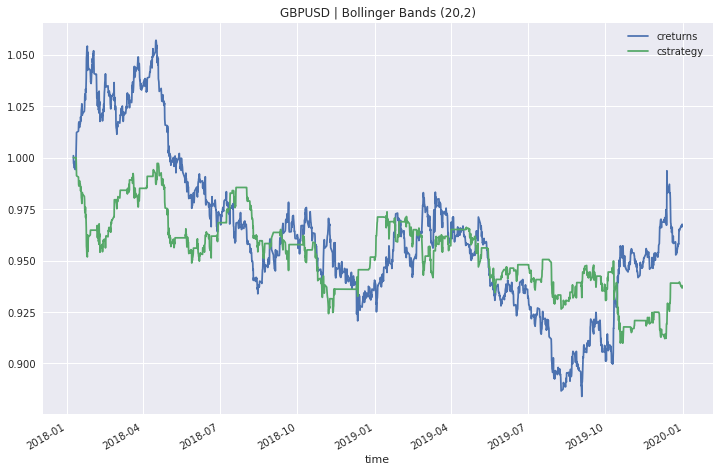

In [373]:
insample.set_parameters(20,2)
insample.test_strategy()
insample.plot_results()

### checkpoint: instantation, get_data, set_parameters work

((47, 2), 1.110892)

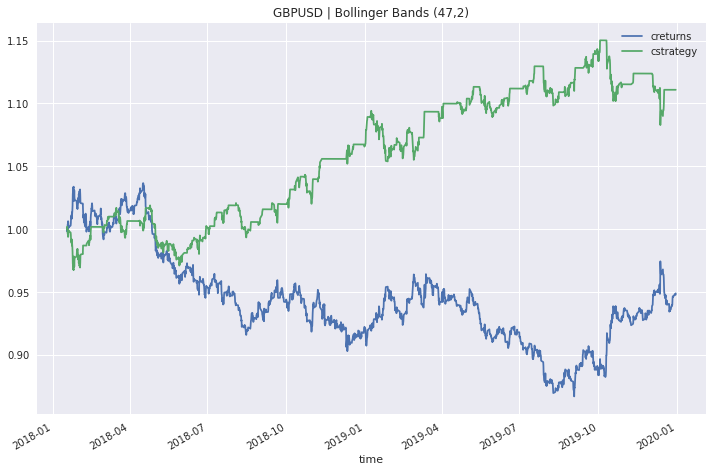

In [374]:
insample.optimize_parameters((2,50,1),(1,50,1))

In [335]:
insample.set_parameters(43,2)
insample.test_strategy()

(1.211986, 0.295884)

In [360]:
insample.results

,price,returns,SMA,upper,lower,distance,position,strategy,trades,ctrades,creturns,cstrategy
time,,,,,,,,,,,,
2018-01-16 16:00:00+00:00,1.226070,0.002540,1.206296,1.227371,1.185220,0.019774,0.0,0.000000,0.0,0.0,1.002543,1.000000
2018-01-16 22:00:00+00:00,1.226720,0.000530,1.206753,1.228730,1.184776,0.019967,0.0,0.000000,0.0,0.0,1.003075,1.000000
2018-01-17 04:00:00+00:00,1.223655,-0.002502,1.207200,1.229758,1.184641,0.016455,0.0,-0.000000,0.0,0.0,1.000568,1.000000
2018-01-17 10:00:00+00:00,1.224275,0.000507,1.207630,1.230775,1.184484,0.016645,0.0,0.000000,0.0,0.0,1.001075,1.000000
2018-01-17 16:00:00+00:00,1.218540,-0.004695,1.207952,1.231314,1.184589,0.010588,0.0,-0.000000,0.0,0.0,0.996386,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,1.112280,1.118443,1.106117,0.007640,-1.0,-0.000065,1.0,93.0,0.915745,1.212456
2019-12-30 04:00:00+00:00,1.119940,0.000018,1.112471,1.119059,1.105884,0.007469,-1.0,-0.000018,0.0,93.0,0.915762,1.212435
2019-12-30 10:00:00+00:00,1.120095,0.000138,1.112634,1.119619,1.105650,0.007461,-1.0,-0.000138,0.0,93.0,0.915889,1.212267


### Number of trades

In [376]:
print("From {} to {}, this strategy performed {:,.0f} trades over {:,.0f} days, \nan average of {:.2f} trades per day.\n\n".\
format(insample.start, insample.end, insample.results.ctrades[-1], insample.results.price.describe().loc['count'],\
       insample.results.trades.describe().loc['count'] / insample.results.ctrades[-1]))

From 2016-01-01 to 2019-12-30, this strategy performed 83 trades over 2,027 days, 
an average of 24.42 trades per day.




### Number of trades plot

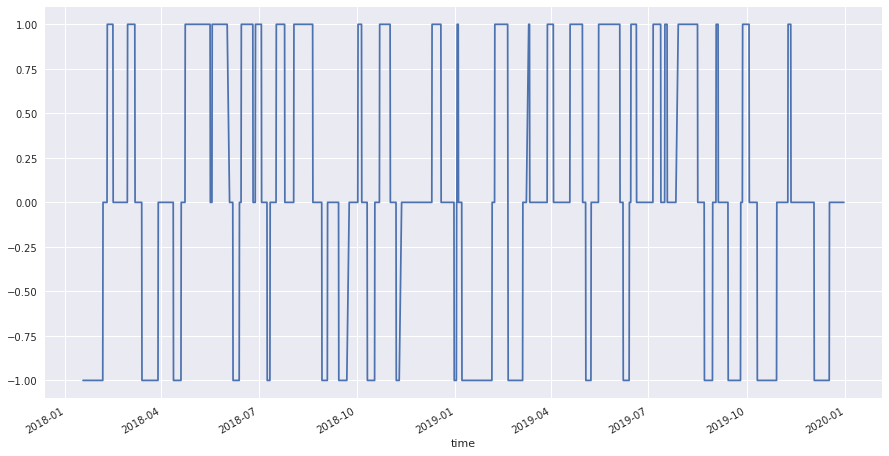

In [375]:
insample.results['position'].plot(figsize=(15,8))
plt.show()

In [377]:
insample.results_overview.sort_values(by=['performance'], ascending=False).head(10)

,SMA,DEV,performance
2206,47,2,1.110892
2108,45,2,1.101393
2304,49,2,1.097664
2059,44,2,1.096439
2157,46,2,1.095504
2255,48,2,1.093277
2010,43,2,1.090705
1961,42,2,1.074083
1912,41,2,1.043909
1081,24,4,1.031109


In [378]:
insample.results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2027 entries, 2018-01-17 16:00:00+00:00 to 2019-12-30 22:00:00+00:00
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      2027 non-null   float64
 1   returns    2027 non-null   float64
 2   SMA        2027 non-null   float64
 3   upper      2027 non-null   float64
 4   lower      2027 non-null   float64
 5   distance   2027 non-null   float64
 6   position   2027 non-null   float64
 7   strategy   2027 non-null   float64
 8   trades     2027 non-null   float64
 9   ctrades    2027 non-null   float64
 10  creturns   2027 non-null   float64
 11  cstrategy  2027 non-null   float64
dtypes: float64(12)
memory usage: 205.9 KB


__AUD/EUR__

## Method get_data()

## Setting new SMA Paramters

## Testing a Strategy

## Plotting the results

## Strategy Optimization

## Splitting get_data() and adding prepare_data() 

## String Representation & Docstrings